# Example 29 - Planar dipping Layers

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 700 m wide (W-E extent) and 788 m high (N-S extent). The model represents southwards dipping planar layers.

The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example29.png" width="800">

Map Source: Unknown

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded form an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example29/'
gg.download_gemgis_data.download_tutorial_data(filename="example29_planar_dipping_layers.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example29.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo29.shp')
topo.head()

,id,Z,geometry
0,None,600,"LINESTRING (15.116 787.112, 22.878 758.803, 29..."
1,None,600,"LINESTRING (450.485 786.656, 457.791 773.642, ..."
2,None,500,"LINESTRING (1.189 660.177, 11.235 642.598, 21...."
3,None,400,"LINESTRING (0.790 532.842, 12.776 506.360, 26...."
4,None,300,"LINESTRING (3.872 351.115, 20.310 331.025, 34...."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=5)

### Plotting the raster

Text(98.40090121128625, 0.5, 'Y [m]')

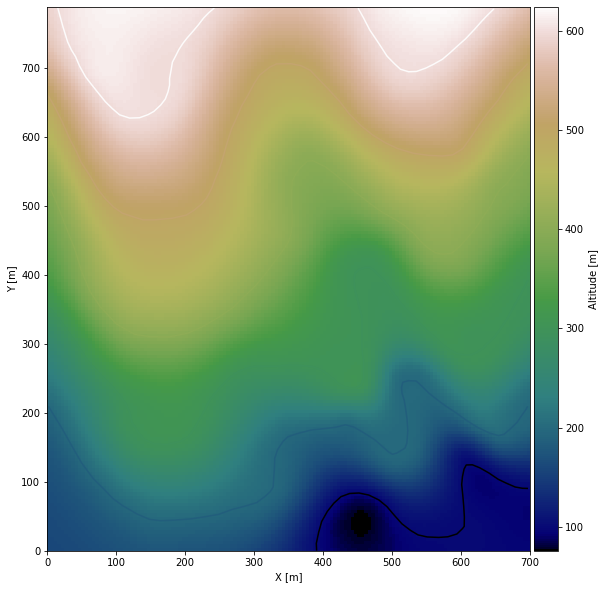

In [6]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

fix, ax = plt.subplots(1, figsize=(10,10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = ax.imshow(topo_raster, origin='lower', extent=[0,700,0,788], cmap='gist_earth')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as as raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster29.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example29.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces29.shp')
interfaces.head()

,id,formation,geometry
0,None,Layer1,"LINESTRING (70.166 0.062, 62.317 20.308, 56.38..."
1,None,Layer1,"LINESTRING (631.470 216.874, 609.097 222.125, ..."


### Extracting XY coordinates from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords = interfaces_coords.sort_values(by='formation', ascending=False)
interfaces_coords.head()

,formation,geometry,X,Y,Z
0,Layer1,POINT (70.166 0.062),70.17,0.06,166.32
107,Layer1,POINT (472.573 494.031),472.57,494.03,393.99
100,Layer1,POINT (524.854 324.632),524.85,324.63,289.36
101,Layer1,POINT (519.147 343.581),519.15,343.58,294.85
102,Layer1,POINT (515.265 366.411),515.27,366.41,304.13


### Plotting the Interface Points

Text(116.99284374939245, 0.5, 'Y [m]')

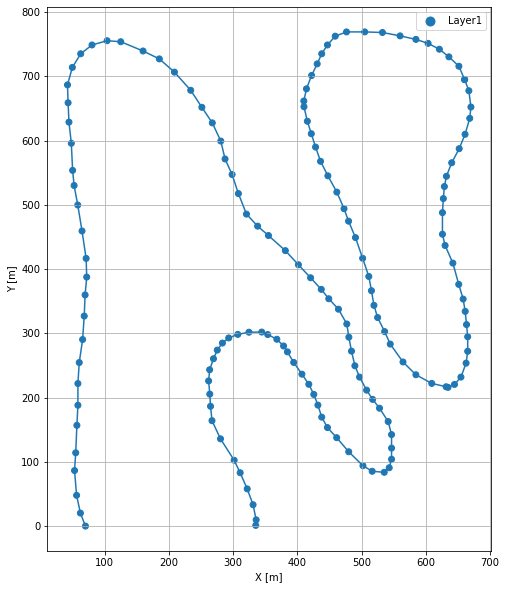

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

<img src="../images/orientations_example29.png" width="800">

In [11]:
strikes = gpd.read_file(file_path + 'strikes29.shp')
strikes

,id,Z,formation,geometry
0,3,600,Layer1a,"LINESTRING (46.044 702.206, 190.042 725.406)"
1,2,500,Layer1a,"LINESTRING (49.510 572.074, 271.908 618.474)"
2,1,400,Layer1a,"LINESTRING (69.244 368.876, 355.641 452.075)"
3,2,300,Layer1b,"LINESTRING (62.310 272.344, 266.042 247.811)"
4,1,200,Layer1b,"LINESTRING (54.844 118.745, 312.974 79.279)"
5,2,300,Layer1c,"LINESTRING (391.907 261.677, 459.106 340.610)"
6,1,200,Layer1c,"LINESTRING (436.706 178.478, 524.172 187.011)"
7,4,600,Layer1d,"LINESTRING (463.373 765.139, 612.705 747.006)"
8,3,500,Layer1d,"LINESTRING (412.173 672.340, 670.304 668.073)"
9,2,400,Layer1d,"LINESTRING (471.906 495.275, 625.505 476.075)"


### Calculate Orientations for each formation

In [12]:
orientations_layer1a = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Layer1a'].sort_values(by='Z', ascending=True).reset_index())
orientations_layer1a

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,28.63,165.42,450.00,POINT (186.576 502.875),1.00,Layer1a,186.58,502.87
1,39.48,168.98,550.00,POINT (139.376 654.540),1.00,Layer1a,139.38,654.54


In [13]:
orientations_layer1b = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Layer1b'].sort_values(by='Z', ascending=True).reset_index())
orientations_layer1b

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,33.10,187.99,250.00,POINT (174.042 179.545),1.00,Layer1b,174.04,179.54


In [14]:
orientations_layer1c = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Layer1c'].sort_values(by='Z', ascending=True).reset_index())
orientations_layer1c

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,46.62,148.69,250.00,POINT (452.973 241.944),1.00,Layer1c,452.97,241.94


In [15]:
orientations_layer1d = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Layer1d'].sort_values(by='Z', ascending=True).reset_index())
orientations_layer1d

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,36.35,187.56,350.00,POINT (570.038 413.942),1.00,Layer1d,570.04,413.94
1,29.60,182.57,450.00,POINT (544.972 577.941),1.00,Layer1d,544.97,577.94
2,52.06,182.45,550.00,POINT (539.639 713.139),1.00,Layer1d,539.64,713.14


### Merging Orientations

In [16]:
import pandas as pd
orientations = pd.concat([orientations_layer1a, orientations_layer1b, orientations_layer1c, orientations_layer1d]).reset_index()
orientations['formation'] = 'Layer1'
orientations

,index,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0,28.63,165.42,450.00,POINT (186.576 502.875),1.00,Layer1,186.58,502.87
1,1,39.48,168.98,550.00,POINT (139.376 654.540),1.00,Layer1,139.38,654.54
2,0,33.10,187.99,250.00,POINT (174.042 179.545),1.00,Layer1,174.04,179.54
3,0,46.62,148.69,250.00,POINT (452.973 241.944),1.00,Layer1,452.97,241.94
4,0,36.35,187.56,350.00,POINT (570.038 413.942),1.00,Layer1,570.04,413.94
5,1,29.60,182.57,450.00,POINT (544.972 577.941),1.00,Layer1,544.97,577.94
6,2,52.06,182.45,550.00,POINT (539.639 713.139),1.00,Layer1,539.64,713.14


### Plotting the Orientations

Text(116.99284374939245, 0.5, 'Y [m]')

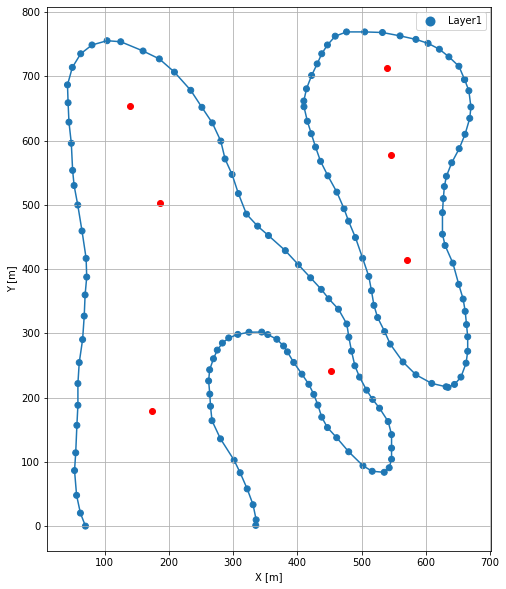

In [17]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [18]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating new Model

In [19]:
geo_model = gp.create_model('Model29')
geo_model

Model29  2021-04-08 11:53

### Initiate Data

In [20]:
gp.init_data(geo_model, [0,700,0,788,0,400], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0].sample(n=100),
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model29  2021-04-08 11:53

### Model Surfaces

In [21]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Layer1,Default series,1,#015482,1


### Mapping the Stack to Surfaces

In [22]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('Layer1'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')

,surface,series,order_surfaces,color,id
0,Layer1,Strata1,1,#015482,1
1,Basement,Strata1,2,#9f0052,2


### Showing the Number of Data Points

In [23]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,Layer1,Strata1,1,#015482,1,100,7
1,Basement,Strata1,2,#9f0052,2,0,0


### Loading Digital Elevation Model

In [24]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster29.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  3.5       ,   3.94      ,   2.        ],
       [  3.5       ,   3.94      ,   6.        ],
       [  3.5       ,   3.94      ,  10.        ],
       ...,
       [697.5       , 775.53164557, 559.49066162],
       [697.5       , 780.51898734, 563.62854004],
       [697.5       , 785.50632911, 567.61871338]])

### Plotting Input Data

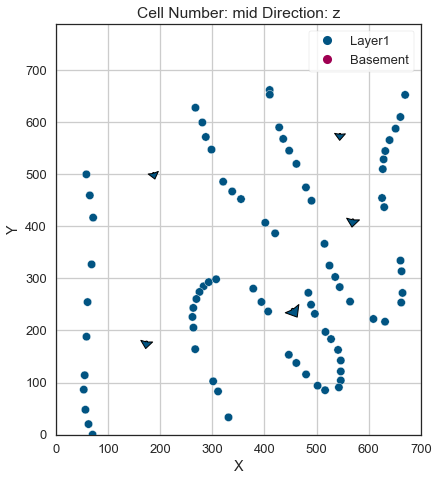

In [25]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

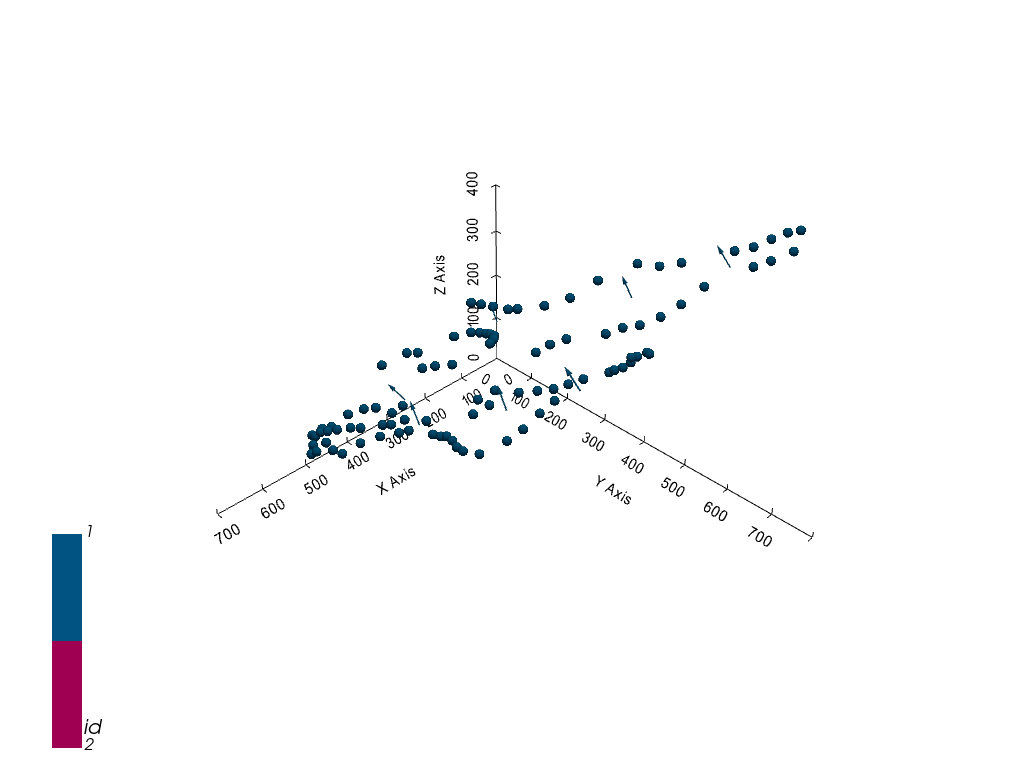

In [26]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [27]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1127.36
$C_o$           30260.57
drift equations      [3]


### Computing Model

In [28]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

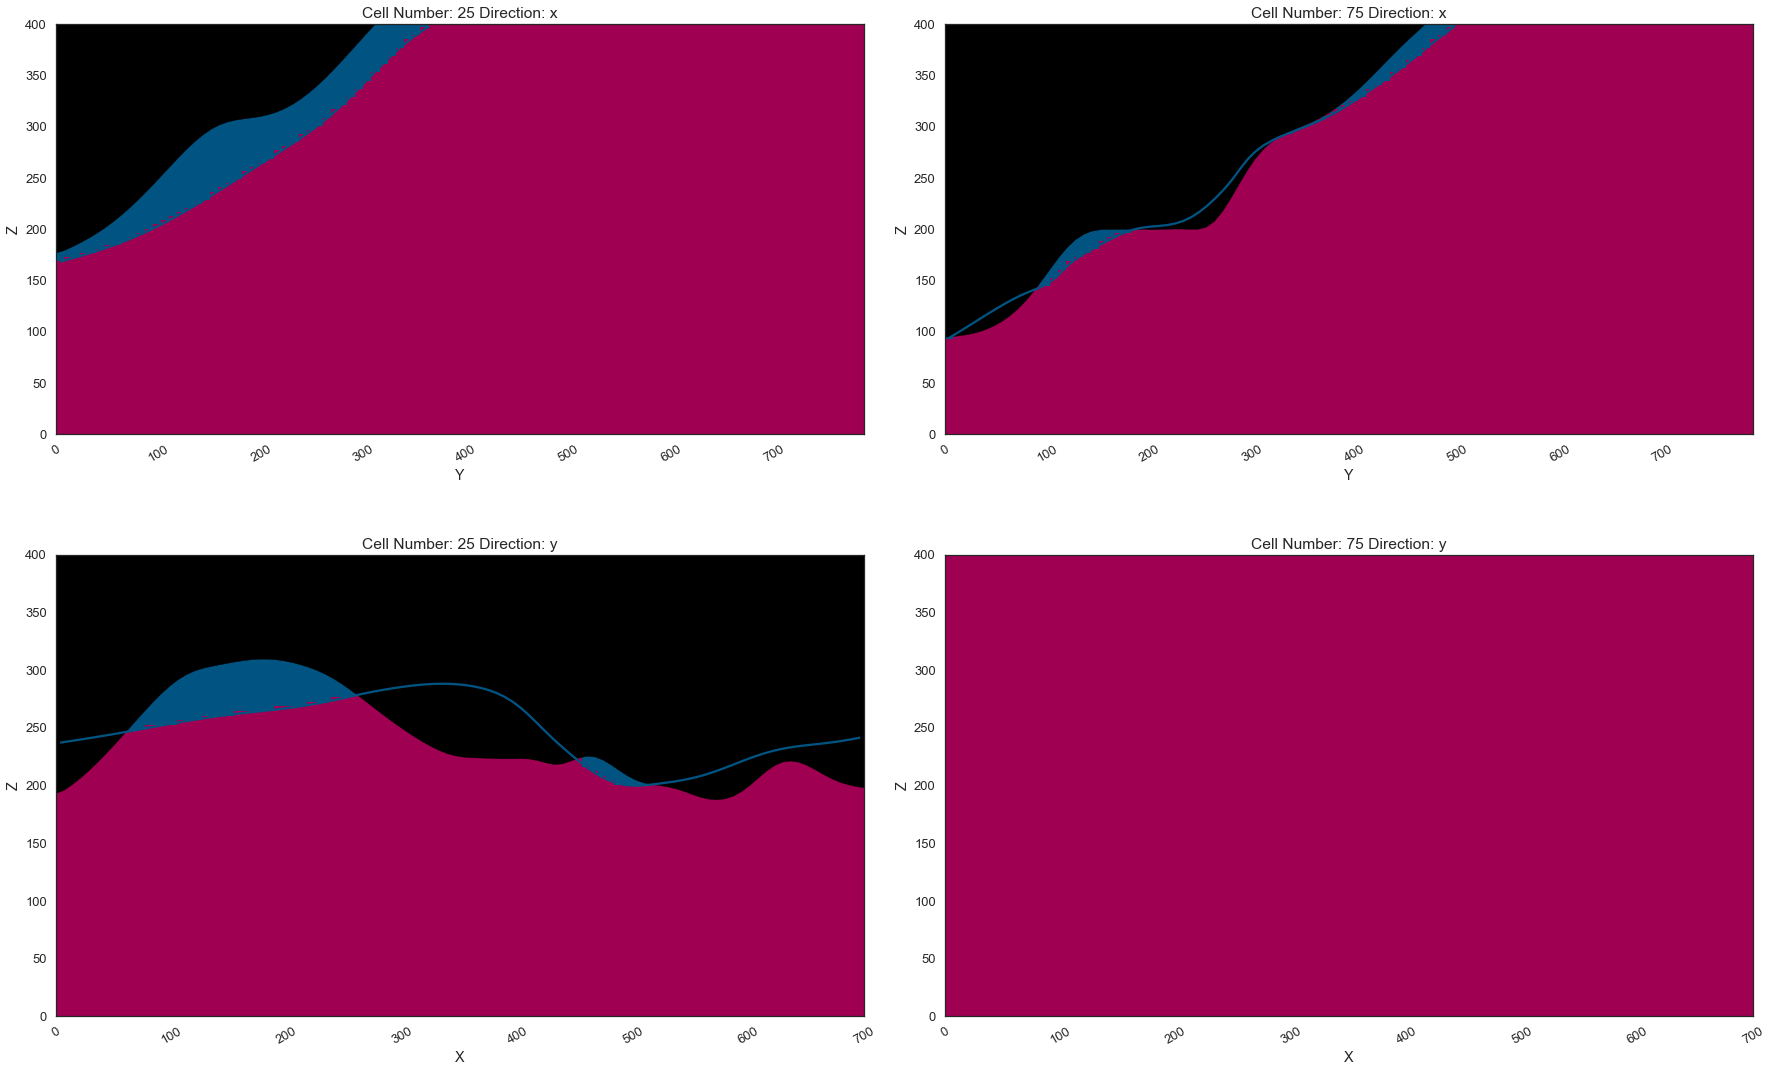

In [29]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

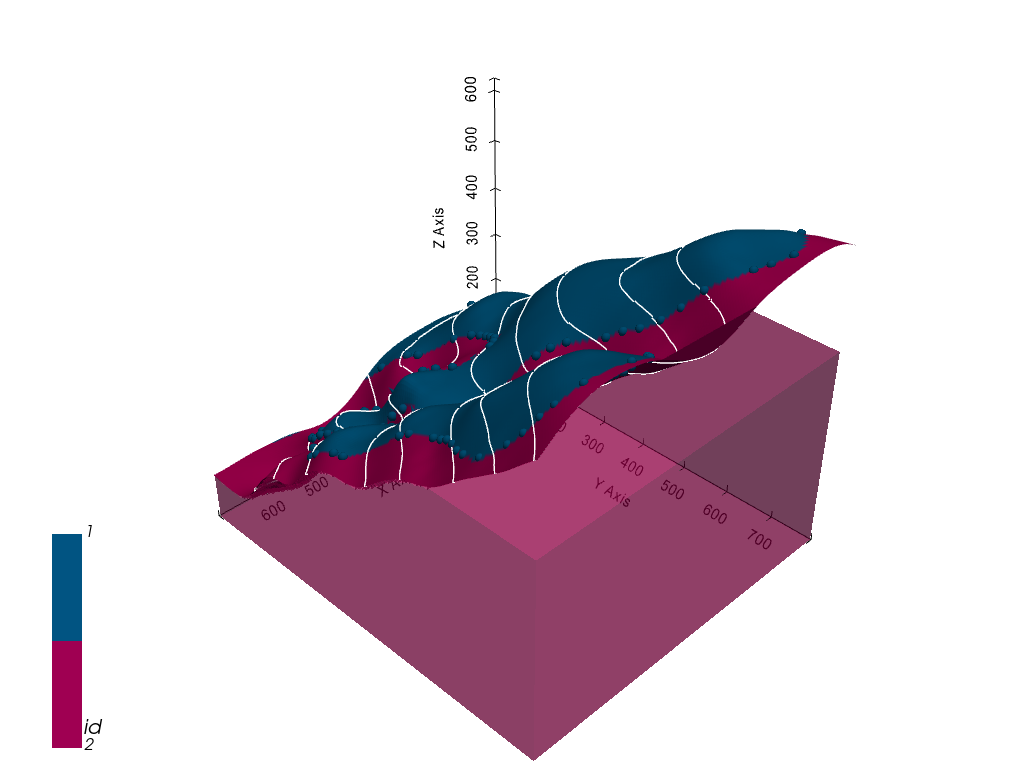

In [30]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)